# GARCH Stock Forecasting

In [1]:
!pip install yfinance
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 990.7/990.7 kB 16.1 MB/s eta 0:00:00a 0:00:01


In [2]:
# =====================================
# 📦 Step 1: Import Libraries
# =====================================
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from datetime import datetime, timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [4]:
# =====================================
# 📅 Step 2: Download Stock Data (Amazon)
# =====================================
end = datetime.now()
start = "2010-01-01" 

df = yf.download('AMZN', start=start, end=end)

# إزالة أي طبقات إضافية في الأعمدة
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.droplevel(1)
    df.columns.name = None
df.head()

/tmp/ipykernel_38/3884870399.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AMZN', start=start, end=end)
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2010-01-04,6.6950,6.8305,6.6570,6.8125,151998000
2010-01-05,6.7345,6.7740,6.5905,6.6715,177038000
2010-01-06,6.6125,6.7365,6.5825,6.7300,143576000
2010-01-07,6.5000,6.6160,6.4400,6.6005,220604000
2010-01-08,6.6760,6.6840,6.4515,6.5280,196610000


Text(0, 0.5, 'Price')

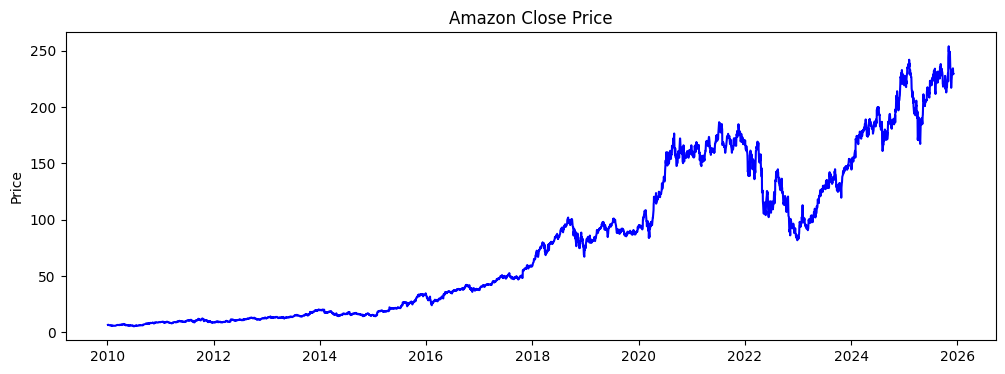

In [5]:
plt.figure(figsize=(12,4))
plt.plot(df['Close'], color='blue')
plt.title('Amazon Close Price')
plt.ylabel('Price')

In [6]:
df['Returns'] = df['Close'].pct_change()
df = df.dropna()

In [7]:
df["Returns"].describe()

count    4006.000000
mean        0.001096
std         0.020711
min        -0.140494
25%        -0.009108
50%         0.000927
75%         0.011948
max         0.157457
Name: Returns, dtype: float64

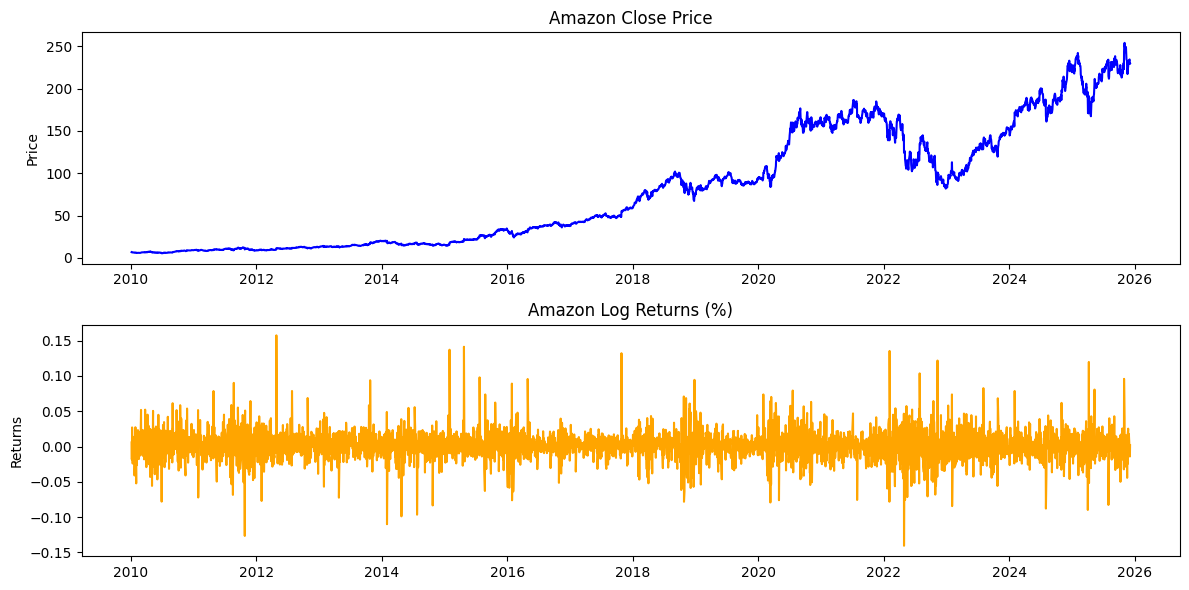

In [8]:
# =====================================
# 📊 Step 4: Visualization
# =====================================
plt.figure(figsize=(12,6))

plt.subplot(2,1,1)
plt.plot(df['Close'], color='blue')
plt.title('Amazon Close Price')
plt.ylabel('Price')

plt.subplot(2,1,2)
plt.plot(df['Returns'], color='orange')
plt.title('Amazon Log Returns (%)')
plt.ylabel('Returns')

plt.tight_layout()
plt.show()

In [9]:
# أكبر 5 تغييرات في العوائد سواء موجبة أو سالبة
top10_changes = df['Returns'].abs().sort_values(ascending=False).head(10)
print("Top 10 changes in returns:")
print(top10_changes)

Top 10 changes in returns:
Date
2012-04-27    0.157457
2015-04-24    0.141311
2022-04-29    0.140494
2015-01-30    0.137116
2022-02-04    0.135359
2017-10-27    0.132164
2011-10-26    0.126568
2022-11-10    0.121778
2025-04-09    0.119770
2014-01-31    0.109972
Name: Returns, dtype: float64


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


<Axes: >

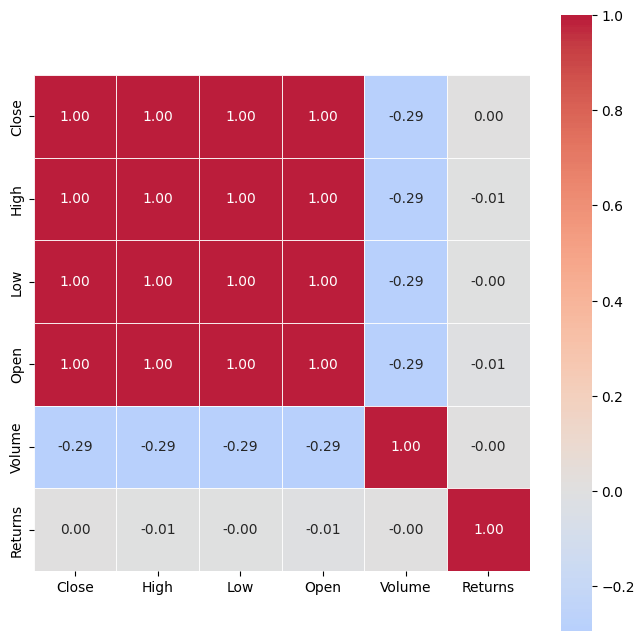

In [10]:
plt.figure(figsize=(8, 8))
corr_mat = df.corr() 
sns.heatmap(corr_mat,square=True, cmap="coolwarm", alpha =0.9, center= 0, linewidths=0.5, annot=True, fmt=".2f")

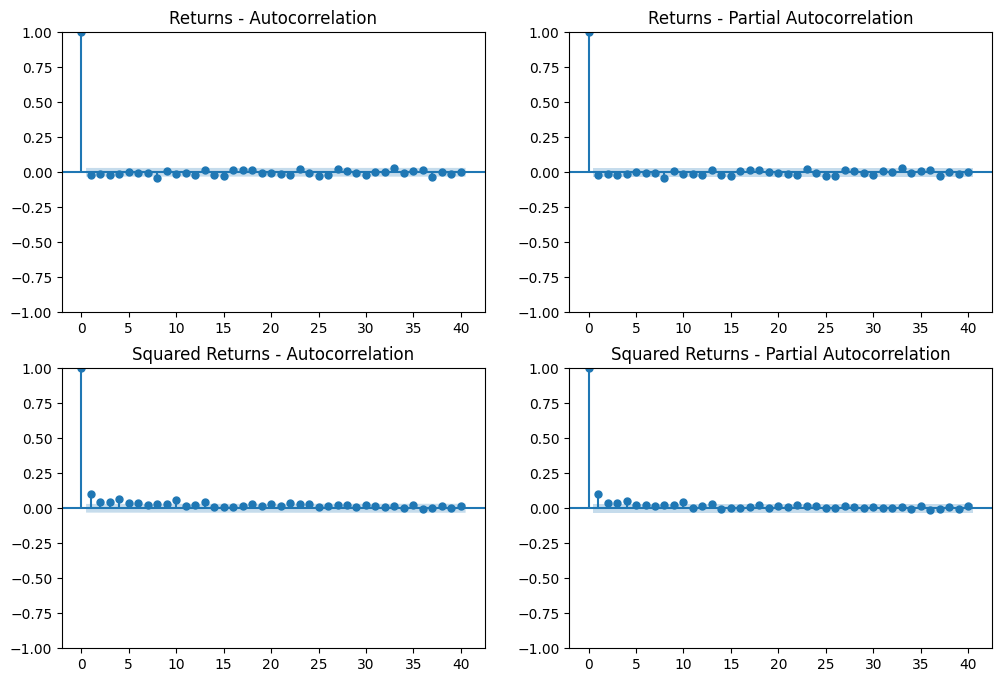

In [11]:
# =====================================
# 📈 Step 5: Autocorrelation Analysis
# =====================================
fig, axes = plt.subplots(2, 2, figsize=(12,8))
plot_acf(df['Returns'], lags=40, ax=axes[0,0])
plot_pacf(df['Returns'], lags=40, ax=axes[0,1])
plot_acf(df['Returns']**2, lags=40, ax=axes[1,0])
plot_pacf(df['Returns']**2, lags=40, ax=axes[1,1])
axes[0,0].set_title('Returns - Autocorrelation')
axes[0,1].set_title('Returns - Partial Autocorrelation')
axes[1,0].set_title('Squared Returns - Autocorrelation')
axes[1,1].set_title('Squared Returns - Partial Autocorrelation')
plt.show()


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7954.02
Distribution:                  Normal   AIC:                           15916.0
Method:            Maximum Likelihood   BIC:                           15941.0
                                        No. Observations:                 3805
Date:                Fri, Dec 05 2025   Df Residuals:                     3804
Time:                        22:06:02   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1621  3.127e-02      5.182  2.192e-07 [  0.101,  0.22

/tmp/ipykernel_38/790779447.py:27: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


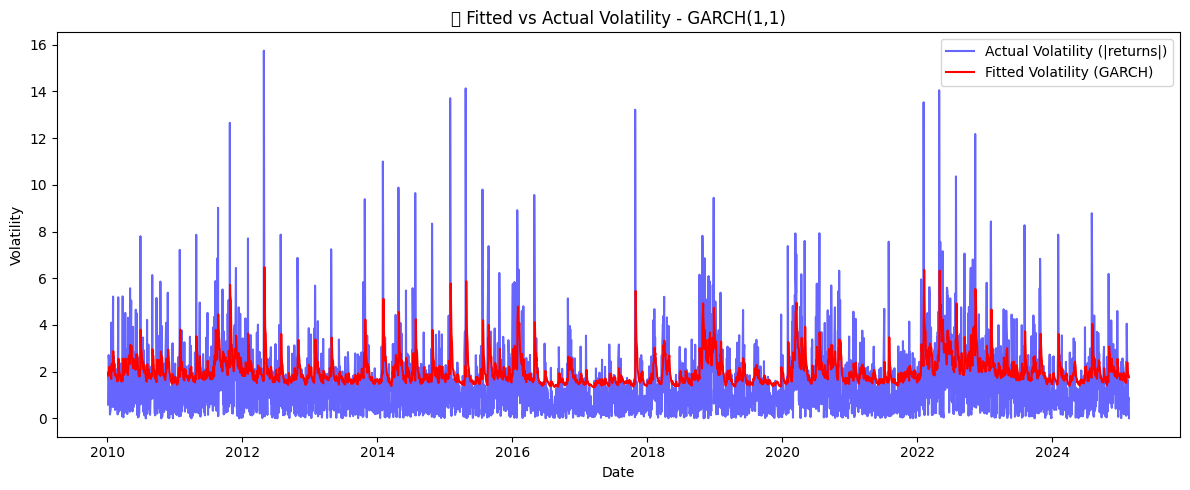

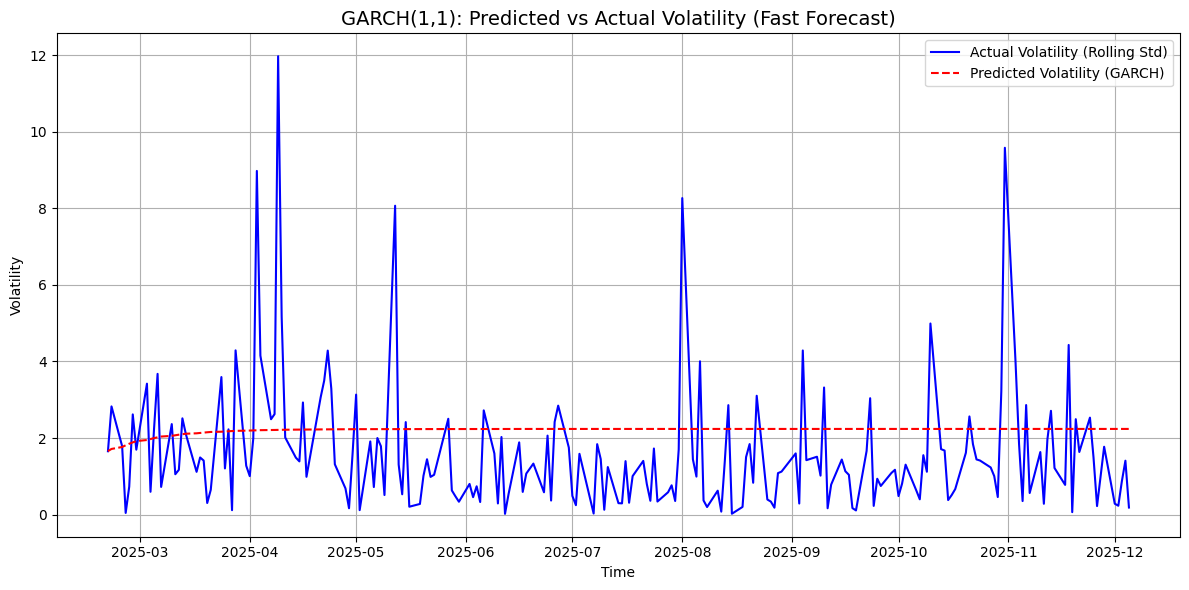

 RMSE between Actual and Predicted Volatility: 1.778601


In [12]:
# Split the data
train_size = int(len(df) * 0.95)
train, test = df['Returns'][:train_size], df['Returns'][train_size:]

# Prepare the data to fit the model
train_scaled = train * 100
test_scaled = test * 100

# Train the model
model = arch_model(train_scaled, vol='GARCH', p=1, q=1, mean='Constant', dist='normal')
res = model.fit(disp="off")
print(res.summary())

# Fitted Volatility 
cond_vol = res.conditional_volatility
#Actual (Training)
realized_vol = np.abs(train_scaled)

# Plot Fitted Volatility vs Actual (Training)
plt.figure(figsize=(12,5))
plt.plot(train.index, realized_vol, label='Actual Volatility (|returns|)', color='blue', alpha=0.6)
plt.plot(train.index, cond_vol, label='Fitted Volatility (GARCH)', color='red')
plt.title('📈 Fitted vs Actual Volatility - GARCH(1,1)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.tight_layout()
plt.show()

# Predict Volatility
forecast = res.forecast(horizon=len(test_scaled), reindex=False).variance.values[-1, :]
pred_vol = np.sqrt(forecast)
pred_vol = pd.Series(pred_vol, index=test_scaled.index)
# Actual (test)
actual_vol = np.abs(test_scaled)

# Plot Predicted vs Actual Volatility
# =====================================
plt.figure(figsize=(12,6))
plt.plot(test.index, actual_vol, label='Actual Volatility (Rolling Std)', color='blue')
plt.plot(test.index, pred_vol, label='Predicted Volatility (GARCH)', color='red', linestyle='--')
plt.title('GARCH(1,1): Predicted vs Actual Volatility (Fast Forecast)', fontsize=14)
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluate Model Performance
rmse = np.sqrt(mean_squared_error(pred_vol,actual_vol))
print(f" RMSE between Actual and Predicted Volatility: {rmse:.6f}")


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7953.99
Distribution:                  Normal   AIC:                           15920.0
Method:            Maximum Likelihood   BIC:                           15957.4
                                        No. Observations:                 3805
Date:                Fri, Dec 05 2025   Df Residuals:                     3804
Time:                        22:06:02   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1616  3.164e-02      5.106  3.289e-07 [9.955e-0

/tmp/ipykernel_38/1632630617.py:26: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


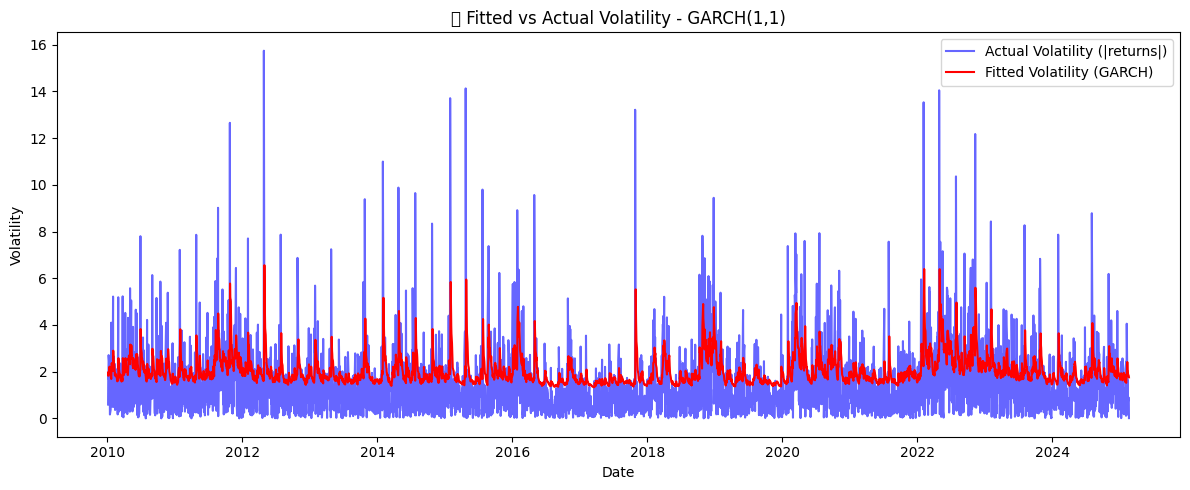

/tmp/ipykernel_38/1632630617.py:66: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


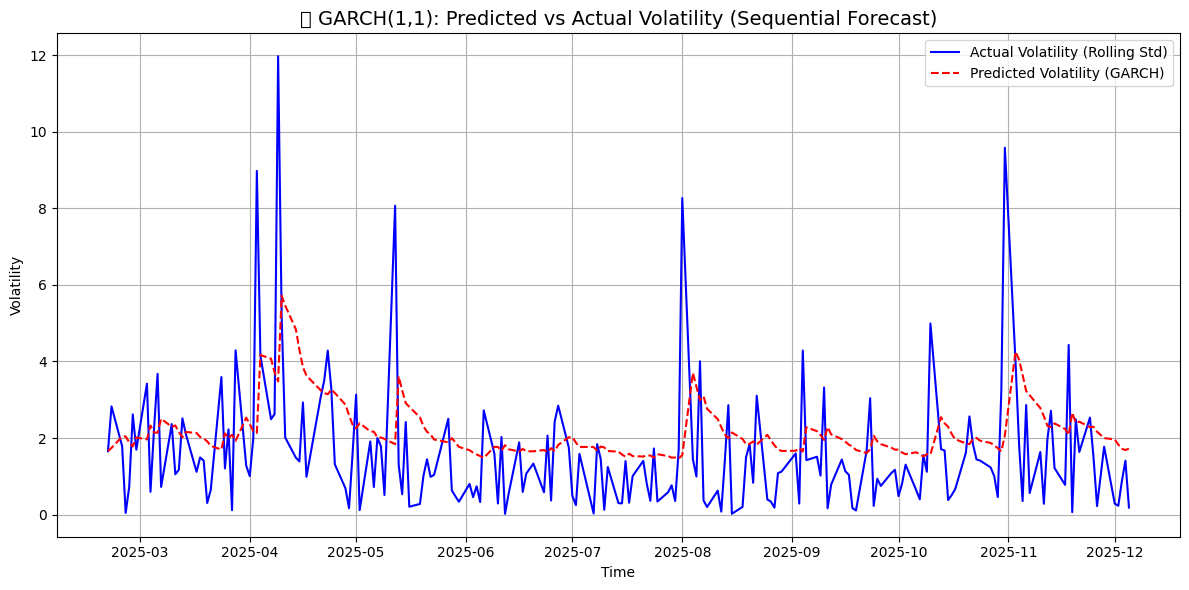

RMSE (Variance)  : 14.9867
MAE (Variance)   : 6.0286


In [13]:
# Split the data
train_size = int(len(df) * 0.95)
train, test = df['Returns'][:train_size], df['Returns'][train_size:]

# Prepare the data 
train_scaled = train * 100
test_scaled = test * 100

# Train the model
model = arch_model(train_scaled, vol='GARCH', p=2, q=2, mean='Constant', dist='normal')
res = model.fit(disp="off")
print(res.summary())

# Fitted Volatility vs Actual (Training)
cond_vol = res.conditional_volatility
realized_vol = np.abs(train_scaled)

# Plot Fitted Volatility vs Actual (Training)
plt.figure(figsize=(12,5))
plt.plot(train.index, realized_vol, label='Actual Volatility (|returns|)', color='blue', alpha=0.6)
plt.plot(train.index, cond_vol, label='Fitted Volatility (GARCH)', color='red')
plt.title('📈 Fitted vs Actual Volatility - GARCH(1,1)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.tight_layout()
plt.show()

# =====================================
# 🔮 Step 7: Sequential Forecasting (Rolling Window, Efficient)
# =====================================
pred_vol = []
history = train_scaled.copy()

for t in range(len(test_scaled)):
    # إعادة استخدام آخر نموذج (بدون إعادة بناء)
    model = arch_model(history, vol='GARCH', p=1, q=1, mean='Constant', dist='normal')
    res = model.fit(disp="off")
    
    # التنبؤ ليوم واحد فقط (horizon=1)
    forecast = res.forecast(horizon=1)
    next_vol = np.sqrt(forecast.variance.values[-1, 0])
    pred_vol.append(next_vol)
    
    # إضافة القيمة الجديدة إلى السلسلة
    new_point = pd.Series([test_scaled.iloc[t]], index=[test_scaled.index[t]])
    history = pd.concat([history, new_point])

pred_vol = pd.Series(pred_vol, index=test_scaled.index)

# =====================================
# 📉 Step 8: Compute Actual (Realized) Volatility
# =====================================
actual_vol = np.abs(test_scaled)
# =====================================
# 📊 Step 9: Plot Predicted vs Actual Volatility
# =====================================
plt.figure(figsize=(12,6))
plt.plot(test.index, actual_vol, label='Actual Volatility (Rolling Std)', color='blue')
plt.plot(test.index, pred_vol, label='Predicted Volatility (GARCH)', color='red', linestyle='--')
plt.title('🔮 GARCH(1,1): Predicted vs Actual Volatility (Sequential Forecast)', fontsize=14)
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =====================================
# 📏 Step 10: Evaluate Model Performance
# =====================================
realized_variance = test_scaled**2
predicted_variance = pred_vol**2

rmse_var  = np.sqrt(np.mean((realized_variance - predicted_variance)**2))
mae_var   = np.mean(np.abs(realized_variance - predicted_variance))
print(f"RMSE (Variance)  : {rmse_var:.4f}")
print(f"MAE (Variance)   : {mae_var:.4f}")

In [14]:
full_data_scaled = pd.concat([train_scaled, test_scaled])
final_model = arch_model(full_data_scaled, vol='GARCH', p=1, q=1, mean='Constant', dist='normal')
final_res = final_model.fit(disp='off')

tomorrow_vol = np.sqrt(final_res.forecast(horizon=1).variance.values[-1, 0])
last_date = df.index[-1]
next_date = last_date + pd.Timedelta(days=1)

print("forecast tomorrow vol")
print(f"{next_date.strftime('%Y-%m-%d')}  {tomorrow_vol:.4f}%")

forecast tomorrow vol
2025-12-06  1.6370%


In [22]:
# =====================================
# 🔮 Step 9: Forecast Volatility (Next 5 Days)
# =====================================
forecast = res.forecast(horizon=5)
vol_forecast = np.sqrt(forecast.variance.values[-1, :])
print("\n📅 Forecasted Volatility (next 5 days):")
print(vol_forecast)


📅 Forecasted Volatility (next 5 days):
[1.77039857 1.79443015 1.81488515 1.83232996 1.84723163]


Text(0.5, 1.0, 'Volatility Prediction - Next 5 Days')

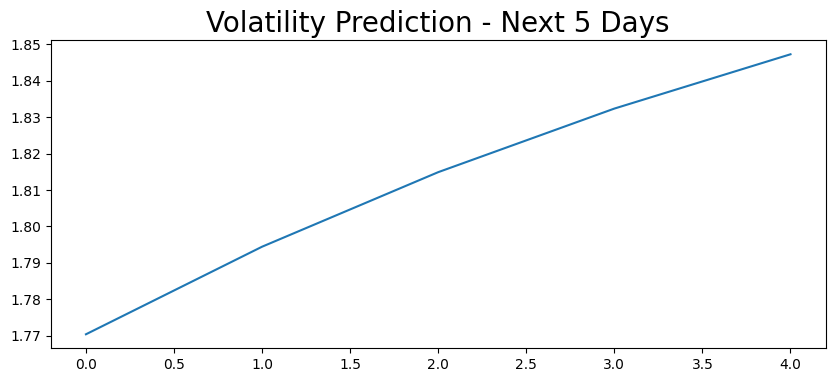

In [24]:
# =====================================
# ✅ Step 11 Prediction - Next 5 Days
# =====================================
plt.figure(figsize=(10,4))
plt.plot(vol_forecast)
plt.title('Volatility Prediction - Next 5 Days', fontsize=20)

# Using Rolling Forcast

/tmp/ipykernel_38/2170404454.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dis = yf.download('AMZN', start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
100%|██████████| 3506/3506 [01:58<00:00, 29.66it/s]


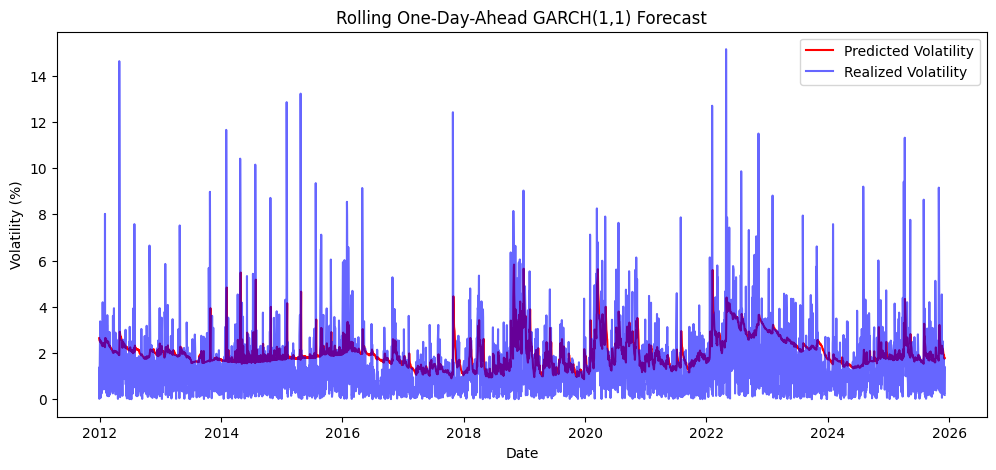


✅ RMSE: 1.5519
🔗 Correlation: 0.2496


In [18]:
# =====================================
# 📦 Step 1: Import Libraries
# =====================================
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from datetime import datetime, timedelta
from tqdm import tqdm

# =====================================
# 📅 Step 2: Download Stock Data (Amazon)
# =====================================
end = datetime.now()
start = "2010-01-01"  # آخر 3 سنوات

dis = yf.download('AMZN', start=start, end=end)

if isinstance(dis.columns, pd.MultiIndex):
    dis.columns = dis.columns.droplevel(1)

# =====================================
# 💹 Step 3: Compute Log Returns
# =====================================
dis['Log_Returns'] = np.log(dis['Close'] / dis['Close'].shift(1))
dis = dis.dropna()

returns = dis['Log_Returns'] * 100  # تحويل إلى نسب مئوية

# =====================================
# ⚙️ Step 4: Rolling Forecast (one-day ahead)
# =====================================
window = 500  # نستخدم آخر 500 يوم لتدريب كل مرة
predicted_vol = []
realized_vol = []

for i in tqdm(range(window, len(returns))):
    train = returns.iloc[i-window:i]  # آخر 500 قيمة فقط
    
    model = arch_model(train, vol='GARCH', p=1, q=1, mean='Constant', dist='t')
    res = model.fit(disp="off")
    
    # التنبؤ بيوم واحد فقط للأمام
    forecast = res.forecast(horizon=1)
    vol_pred = np.sqrt(forecast.variance.values[-1, 0])
    
    predicted_vol.append(vol_pred)
    
    # التقلب الفعلي (returns²)
    realized_vol.append(returns.iloc[i] ** 2)

# =====================================
# 📈 Step 5: Create Forecast DataFrame
# =====================================
forecast_df = pd.DataFrame({
    'Date': returns.index[window:],
    'Predicted_Volatility': predicted_vol,
    'Realized_Volatility': np.sqrt(realized_vol)
}).set_index('Date')

# =====================================
# 📉 Step 6: Plot Results
# =====================================
plt.figure(figsize=(12,5))
plt.plot(forecast_df['Predicted_Volatility'], label='Predicted Volatility', color='red')
plt.plot(forecast_df['Realized_Volatility'], label='Realized Volatility', color='blue', alpha=0.6)
plt.title('Rolling One-Day-Ahead GARCH(1,1) Forecast')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.legend()
plt.show()

# =====================================
# 📊 Step 7: Evaluate Accuracy (RMSE & Correlation)
# =====================================
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(forecast_df['Realized_Volatility'],
                                  forecast_df['Predicted_Volatility']))

corr = np.corrcoef(forecast_df['Realized_Volatility'],
                   forecast_df['Predicted_Volatility'])[0, 1]

print(f"\n✅ RMSE: {rmse:.4f}")
print(f"🔗 Correlation: {corr:.4f}")


In [19]:
# -*- coding: utf-8 -*-
# Predict tomorrow's volatility (one-day-ahead) using rolling GARCH(1,1) with Student-t
import yfinance as yf
import pandas as pd
import numpy as np
from arch import arch_model
from datetime import datetime, timedelta

def predict_tomorrow_vol(ticker='AMZN', years=3, window=500, dist='t'):
    """
    Downloads recent data for `ticker`, computes log-returns, fits GARCH(1,1) on the last `window`
    days and returns the predicted volatility (sigma) for next day.
    - returns: dict with predicted_sigma (in %), predicted_variance, last_date_used
    """
    end = datetime.now()
    start = end - timedelta(days=365 * years)
    df = yf.download(ticker, start=start, end=end, progress=False)

    if df.empty:
        raise ValueError("No data downloaded. Check ticker or internet connection.")

    # clean multiindex if exists
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.droplevel(1)

    # compute log returns (in %)
    df['log_ret'] = np.log(df['Close'] / df['Close'].shift(1))
    df = df.dropna()
    returns = df['log_ret'] * 100

    if len(returns) < window + 1:
        raise ValueError(f"Not enough data for the chosen window={window}. Have {len(returns)} observations.")

    # use the last `window` observations to fit the model (rolling one-step forecast but here only final step)
    train = returns.iloc[-window:]
    model = arch_model(train, vol='GARCH', p=1, q=1, mean='Constant', dist=dist)
    res = model.fit(disp='off')

    # one-step ahead forecast (next day)
    forecast = res.forecast(horizon=1, reindex=False)
    var_pred = forecast.variance.values[-1, 0]   # variance predicted for next day
    sigma_pred = np.sqrt(var_pred)              # std deviation (in same units as returns, i.e., %)

    result = {
        'ticker': ticker,
        'last_date_used': df.index[-1].strftime('%Y-%m-%d'),
        'predicted_variance': float(var_pred),
        'predicted_sigma_percent': float(sigma_pred),  # % (because returns were multiplied by 100)
        'model_summary': res.summary().as_text()
    }
    return result

# Example usage:
if __name__ == "__main__":
    out = predict_tomorrow_vol(ticker='AMZN', years=3, window=500, dist='t')
    print("Last date used:", out['last_date_used'])
    print("Predicted volatility (sigma) for tomorrow: {:.4f} %".format(out['predicted_sigma_percent']))
    print("Predicted variance for tomorrow: {:.6f}".format(out['predicted_variance']))
    # optionally print model summary:
    print("\nModel summary (truncated):\n")
    print(out['model_summary'])


Last date used: 2025-12-05
Predicted volatility (sigma) for tomorrow: 1.7244 %
Predicted variance for tomorrow: 2.973659

Model summary (truncated):

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                      log_ret   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -999.531
Distribution:      Standardized Student's t   AIC:                           2009.06
Method:                  Maximum Likelihood   BIC:                           2030.14
                                              No. Observations:                  500
Date:                      Fri, Dec 05 2025   Df Residuals:                      499
Time:                              22:08:12   Df Model:                            1
                                 Mean Model                                
         

/tmp/ipykernel_38/2036881774.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [25]:
# Import Libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Download Stock Data
end = '2023-12-31'
start = '2010-01-01'

df = yf.download('AMZN', start=start, end=end)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.droplevel(1)
    df.columns.name = None
df.head()


#Create Features
df['Return_lag1'] = df['Close'].pct_change().shift(1)
df['High_lag1'] = df['High'].shift(1)
df['Low_lag1'] = df['Low'].shift(1)
df['Volume_lag1'] = df['Volume'].shift(1)

df['Close_lag1'] = df['Close'].shift(1)
df['Close_lag2'] = df['Close'].shift(2)
df['Close_lag3'] = df['Close'].shift(3)
df['Close_MA5'] = df['Close'].rolling(window=5).mean().shift(1)
df['Close_MA10'] = df['Close'].rolling(window=10).mean().shift(1)
df = df.dropna()


#Split The data and train the model
target_col = "Close" 
split_index = int(len(df) * 0.8)
train_data = df.iloc[:split_index]
test_data = df.iloc[split_index:]
print(f"✅ Train shape: {train_data.shape}")
print(f"✅ Test shape: {test_data.shape}")

# Train_data and Test data
X_train = train_data.drop(['Close','High', 'Low', 'Open', 'Volume'],axis=1)
y_train = train_data[target_col]
X_test  = test_data.drop(['Close','High', 'Low', 'Open', 'Volume'],axis=1)
y_test  = test_data[target_col]


# Random Forest model
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)


# Metrices
# RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# MAE
mae = mean_absolute_error(y_test, y_pred)
# MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
# R² 
r2 = r2_score(y_test, y_pred)
# Zero-Mean R²
y_test_zm = y_test - np.mean(y_test)
y_pred_zm = y_pred - np.mean(y_pred)
zero_mean_r2 = 1 - np.sum((y_test_zm - y_pred_zm)**2) / np.sum(y_test_zm**2)
# Directional Accuracy
direction_real = np.sign(np.diff(y_test))
direction_pred = np.sign(np.diff(y_pred))
directional_acc = np.mean(direction_real == direction_pred) * 100


# Results
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")
print(f"Zero-Mean R²: {zero_mean_r2:.4f}")
print(f"Directional Accuracy: {directional_acc:.2f}%")

/tmp/ipykernel_38/22334875.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AMZN', start=start, end=end)
[*********************100%***********************]  1 of 1 completed


✅ Train shape: (2809, 14)
✅ Test shape: (703, 14)
RMSE: 4.8292
MAE: 3.5311
MAPE: 2.63%
R²: 0.9697
Zero-Mean R²: 0.9706
Directional Accuracy: 50.43%


In [26]:
# ===================================
# Import Libraries
# ===================================
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

# ===================================
# Download Stock Data
# ===================================
end = '2023-12-31'
start = '2010-01-01'

df = yf.download('AMZN', start=start, end=end)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.droplevel(1)
    df.columns.name = None

# ===================================
# Create Features
# ===================================
df['Return_lag1'] = df['Close'].pct_change().shift(1)
df['High_lag1'] = df['High'].shift(1)
df['Low_lag1'] = df['Low'].shift(1)
df['Volume_lag1'] = df['Volume'].shift(1)

df['Close_lag1'] = df['Close'].shift(1)
df['Close_lag2'] = df['Close'].shift(2)
df['Close_lag3'] = df['Close'].shift(3)
df['Close_MA5'] = df['Close'].rolling(window=5).mean().shift(1)
df['Close_MA10'] = df['Close'].rolling(window=10).mean().shift(1)

df = df.dropna()

# ===================================
# Split Data
# ===================================
target_col = "Close" 
split_index = int(len(df) * 0.8)
train_data = df.iloc[:split_index]
test_data = df.iloc[split_index:]

print(f"✅ Train shape: {train_data.shape}")
print(f"✅ Test shape: {test_data.shape}")

X_train = train_data.drop(['Close','High', 'Low', 'Open', 'Volume'], axis=1)
y_train = train_data[target_col]
X_test  = test_data.drop(['Close','High', 'Low', 'Open', 'Volume'], axis=1)
y_test  = test_data[target_col]

# ===================================
# XGBoost Model
# ===================================
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

# ===================================
# Metrics
# ===================================
# RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# MAE
mae = mean_absolute_error(y_test, y_pred)
# MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
# R² 
r2 = r2_score(y_test, y_pred)
# Zero-Mean R²
y_test_zm = y_test - np.mean(y_test)
y_pred_zm = y_pred - np.mean(y_pred)
zero_mean_r2 = 1 - np.sum((y_test_zm - y_pred_zm)**2) / np.sum(y_test_zm**2)
# Directional Accuracy
direction_real = np.sign(np.diff(y_test))
direction_pred = np.sign(np.diff(y_pred))
directional_acc = np.mean(direction_real == direction_pred) * 100

# ===================================
# Results
# ===================================
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")
print(f"Zero-Mean R²: {zero_mean_r2:.4f}")
print(f"Directional Accuracy: {directional_acc:.2f}%")


/tmp/ipykernel_38/3501989046.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AMZN', start=start, end=end)
[*********************100%***********************]  1 of 1 completed


✅ Train shape: (2809, 14)
✅ Test shape: (703, 14)
RMSE: 4.4508
MAE: 3.2765
MAPE: 2.43%
R²: 0.9743
Zero-Mean R²: 0.9746
Directional Accuracy: 51.57%


In [27]:
# ===================================
# Import Libraries
# ===================================
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# ===================================
# Download Stock Data
# ===================================
end = '2023-12-31'
start = '2010-01-01'

df = yf.download('AMZN', start=start, end=end)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.droplevel(1)
    df.columns.name = None

# ===================================
# Create Features
# ===================================
df['Return_lag1'] = df['Close'].pct_change().shift(1)
df['High_lag1'] = df['High'].shift(1)
df['Low_lag1'] = df['Low'].shift(1)
df['Volume_lag1'] = df['Volume'].shift(1)

df['Close_lag1'] = df['Close'].shift(1)
df['Close_lag2'] = df['Close'].shift(2)
df['Close_lag3'] = df['Close'].shift(3)
df['Close_MA5'] = df['Close'].rolling(window=5).mean().shift(1)
df['Close_MA10'] = df['Close'].rolling(window=10).mean().shift(1)

df = df.dropna()

# ===================================
# Split Data
# ===================================
target_col = "Close" 
split_index = int(len(df) * 0.8)
train_data = df.iloc[:split_index]
test_data = df.iloc[split_index:]

print(f"✅ Train shape: {train_data.shape}")
print(f"✅ Test shape: {test_data.shape}")

X_train = train_data.drop(['Close','High', 'Low', 'Open', 'Volume'], axis=1)
y_train = train_data[target_col]
X_test  = test_data.drop(['Close','High', 'Low', 'Open', 'Volume'], axis=1)
y_test  = test_data[target_col]

# ===================================
# Scale Data
# ===================================
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1,1))

# ===================================
# Reshape for LSTM [samples, timesteps, features]
# ===================================
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# ===================================
# Build LSTM Model
# ===================================
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train
model.fit(X_train_lstm, y_train_scaled, epochs=50, batch_size=32, verbose=1)

# Predict
y_pred_scaled = model.predict(X_test_lstm)
y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()  # 🔹 flatten لتجنب خطأ الأبعاد

# ===================================
# Metrics
# ===================================
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

y_test_zm = y_test - np.mean(y_test)
y_pred_zm = y_pred - np.mean(y_pred)
zero_mean_r2 = 1 - np.sum((y_test_zm - y_pred_zm)**2) / np.sum(y_test_zm**2)

direction_real = np.sign(np.diff(y_test))
direction_pred = np.sign(np.diff(y_pred))
directional_acc = np.mean(direction_real == direction_pred) * 100

# ===================================
# Results
# ===================================
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")
print(f"Zero-Mean R²: {zero_mean_r2:.4f}")
print(f"Directional Accuracy: {directional_acc:.2f}%")


2025-12-05 22:09:02.527158: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764972542.738324      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764972542.810836      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_38/1212930682.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AMZN', start=start, end=end)
[*********************100%***********************]  1 of 1 completed


✅ Train shape: (2809, 14)
✅ Test shape: (703, 14)


I0000 00:00:1764972554.940630      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764972554.941326      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50


I0000 00:00:1764972558.243493     138 service.cc:148] XLA service 0x7fa3e00025b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764972558.244296     138 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764972558.244317     138 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764972558.531701     138 cuda_dnn.cc:529] Loaded cuDNN version 90300


84/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0647

I0000 00:00:1764972559.190739     138 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0630
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9523e-04
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1687e-04
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.4692e-05
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.6880e-05
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.6264e-05
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.6366e-05
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5352e-05
Epoch 9/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6321e-05
Epoch 10/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8190e-05
Epoch 11/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5541e-05
Epoch 12/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9273e-05
Epoch 13/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7674e-05
Epoch 14/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.0738e-05
Epoch 15/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2

In [28]:
# ===================================
# Import Libraries
# ===================================
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# ===================================
# Download Stock Data
# ===================================
end = '2023-12-31'
start = '2010-01-01'

df = yf.download('AMZN', start=start, end=end)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.droplevel(1)
    df.columns.name = None

# ===================================
# Create Features
# ===================================
df['Return_lag1'] = df['Close'].pct_change().shift(1)
df['High_lag1'] = df['High'].shift(1)
df['Low_lag1'] = df['Low'].shift(1)
df['Volume_lag1'] = df['Volume'].shift(1)

df['Close_lag1'] = df['Close'].shift(1)
df['Close_lag2'] = df['Close'].shift(2)
df['Close_lag3'] = df['Close'].shift(3)
df['Close_MA5'] = df['Close'].rolling(window=5).mean().shift(1)
df['Close_MA10'] = df['Close'].rolling(window=10).mean().shift(1)

df = df.dropna()

# ===================================
# Split Data
# ===================================
target_col = "Close" 
split_index = int(len(df) * 0.8)
train_data = df.iloc[:split_index]
test_data = df.iloc[split_index:]

X_train = train_data.drop(['Close','High', 'Low', 'Open', 'Volume'], axis=1)
y_train = train_data[target_col]
X_test  = test_data.drop(['Close','High', 'Low', 'Open', 'Volume'], axis=1)
y_test  = test_data[target_col]

# ===================================
# Scale Data for LSTM
# ===================================
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1,1))

X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# ===================================
# Train LSTM
# ===================================
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train_scaled, epochs=50, batch_size=32, verbose=1)

# Predict LSTM
y_pred_lstm_train = scaler_y.inverse_transform(lstm_model.predict(X_train_lstm)).flatten()
y_pred_lstm_test = scaler_y.inverse_transform(lstm_model.predict(X_test_lstm)).flatten()

# ===================================
# Train Random Forest & XGBoost
# ===================================
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf_train = rf.predict(X_train)
y_pred_rf_test = rf.predict(X_test)

xgb = XGBRegressor(n_estimators=200, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb_train = xgb.predict(X_train)
y_pred_xgb_test = xgb.predict(X_test)

# ===================================
# Prepare Stacking Features
# ===================================
stack_train = pd.DataFrame({
    'RF': y_pred_rf_train,
    'XGB': y_pred_xgb_train,
    'LSTM': y_pred_lstm_train
})

stack_test = pd.DataFrame({
    'RF': y_pred_rf_test,
    'XGB': y_pred_xgb_test,
    'LSTM': y_pred_lstm_test
})

# ===================================
# Meta-model (Linear Regression)
# ===================================
meta_model = RandomForestRegressor()
meta_model.fit(stack_train, y_train)
y_pred_stack = meta_model.predict(stack_test)

# ===================================
# Metrics
# ===================================
rmse = np.sqrt(mean_squared_error(y_test, y_pred_stack))
mae = mean_absolute_error(y_test, y_pred_stack)
mape = np.mean(np.abs((y_test - y_pred_stack) / y_test)) * 100
r2 = r2_score(y_test, y_pred_stack)

y_test_zm = y_test - np.mean(y_test)
y_pred_zm = y_pred_stack - np.mean(y_pred_stack)
zero_mean_r2 = 1 - np.sum((y_test_zm - y_pred_zm)**2) / np.sum(y_test_zm**2)

direction_real = np.sign(np.diff(y_test))
direction_pred = np.sign(np.diff(y_pred_stack))
directional_acc = np.mean(direction_real == direction_pred) * 100

# ===================================
# Results
# ===================================
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")
print(f"Zero-Mean R²: {zero_mean_r2:.4f}")
print(f"Directional Accuracy: {directional_acc:.2f}%")


/tmp/ipykernel_38/336115399.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AMZN', start=start, end=end)
[*********************100%***********************]  1 of 1 completed

Epoch 1/50



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0494
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9200e-04
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1407e-04
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.4859e-05
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.2746e-05
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.2379e-05
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.2804e-05
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2463e-05
Epoch 9/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.4634e-05
Epoch 10/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7794e-05
Epoch 11/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3762e-05
Epoch 12/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6985e-05
Epoch 13/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8729e-05
Epoch 14/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0544e-05
Epoch 15/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2m

In [29]:
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

rf = RandomForestRegressor(n_estimators=200, random_state=42)
xgb = XGBRegressor(n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42)

voting_model = VotingRegressor(estimators=[('rf', rf), ('xgb', xgb)])
voting_model.fit(X_train, y_train)
y_pred_voting = voting_model.predict(X_test)

# ===================================
# Metrics
# ===================================
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

y_test_zm = y_test - np.mean(y_test)
y_pred_zm = y_pred - np.mean(y_pred)
zero_mean_r2 = 1 - np.sum((y_test_zm - y_pred_zm)**2) / np.sum(y_test_zm**2)

direction_real = np.sign(np.diff(y_test))
direction_pred = np.sign(np.diff(y_pred))
directional_acc = np.mean(direction_real == direction_pred) * 100

# ===================================
# Results
# ===================================
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")
print(f"Zero-Mean R²: {zero_mean_r2:.4f}")
print(f"Directional Accuracy: {directional_acc:.2f}%")

RMSE: 3.4957
MAE: 2.5681
MAPE: 1.98%
R²: 0.9841
Zero-Mean R²: 0.9858
Directional Accuracy: 49.29%
